In [1]:
!pip install -U hiplot
!pip install keras-tuner

     |████████████████████████████████| 695 kB 4.4 MB/s 
     |████████████████████████████████| 357 kB 9.1 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
from pandas_profiling import ProfileReport

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import regularizer
from tensorflow.keras.regularizers import l2

#import keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel 

from keras.utils import np_utils

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
2.3.1


In [3]:
df = pd.read_csv("../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")
print(df.shape)


(35887, 3)


In [4]:
print(df.describe)

<bound method NDFrame.describe of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 c

In [5]:
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [6]:
prof = ProfileReport(df)
prof.to_file(output_file='data_report.html')

In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_num_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

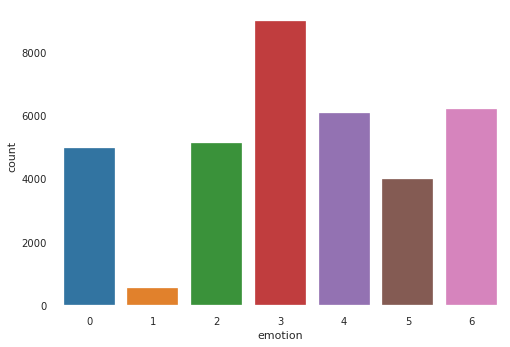

In [10]:
sns.countplot(df.emotion)
pyplot.show()

In [11]:
# data manipulation for heatmap
heatmap_df=df.drop(['pixels'], axis=1)
usage_text_to_num = {'Training':0, 'PrivateTest':1}

In [12]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

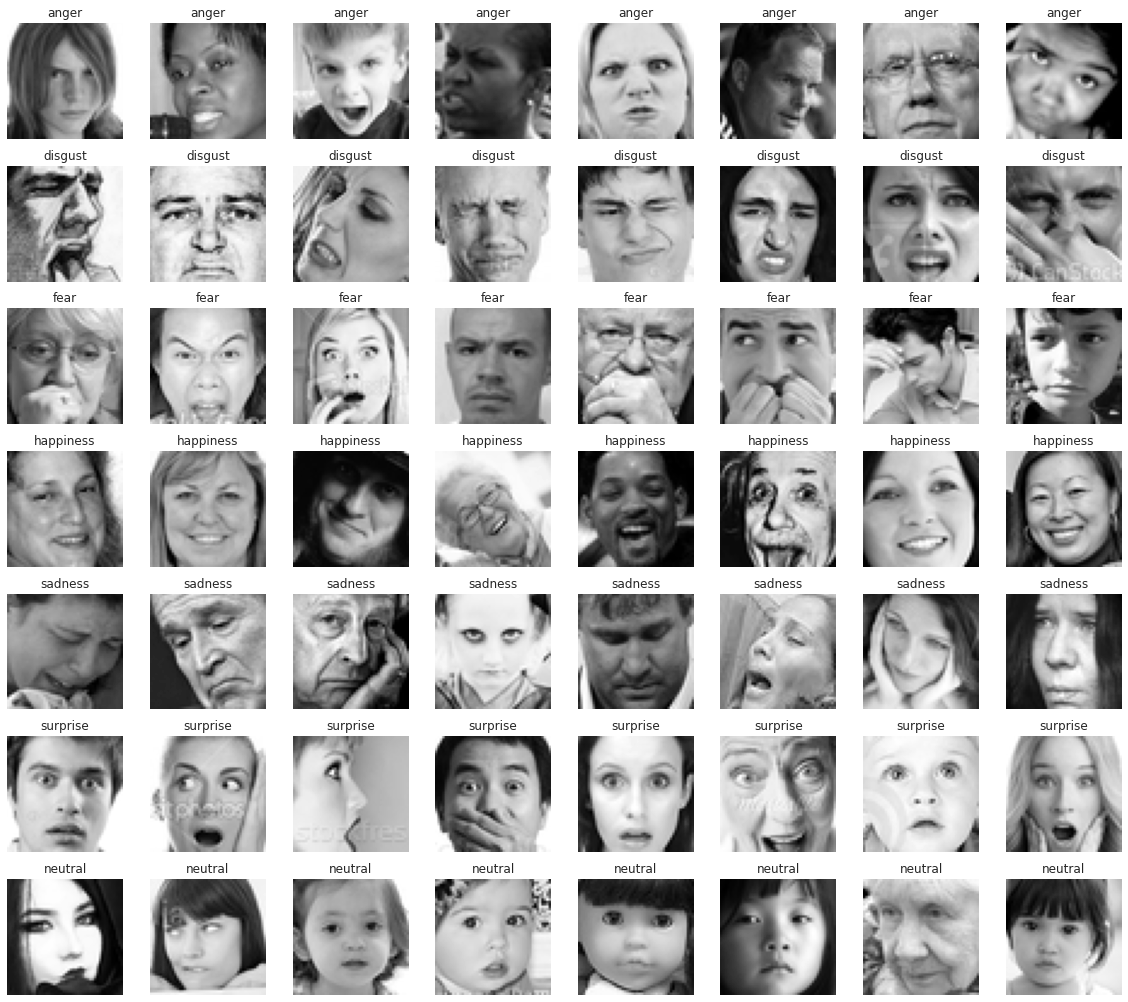

In [13]:
fig = pyplot.figure(1, (16, 16))

sub_pos = 0
LOC=16
for label in sorted(df.emotion.unique()):
    for j in range(8):
        pixel = df[df.emotion==label].pixels.iloc[LOC]
        pixel = np.array(pixel.split(' ')).reshape(48, 48).astype('float32')
        
        LOC += 1
        sub_pos += 1
        ax = pyplot.subplot(8, 8, sub_pos)
        ax.imshow(pixel, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_num_to_text[label])
        pyplot.tight_layout()

In [14]:
# Here I combine Anger and Disgust. 
df['emotion'] = df['emotion'].replace([1],0)

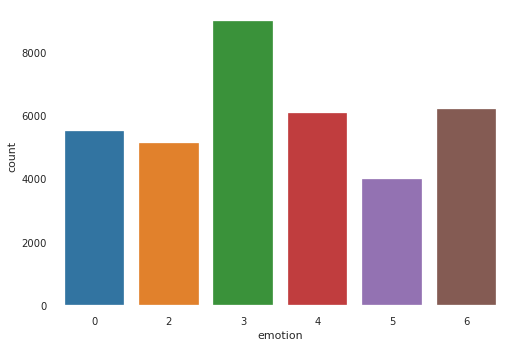

In [15]:
sns.countplot(df.emotion)
pyplot.show()
#The column '1' disappeared

In [16]:
INTERESTED_LABELS = [0, 2, 3, 4, 5, 6]

In [17]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.emotion.value_counts()

3    8989
6    6198
4    6077
0    5500
2    5121
5    4002
Name: emotion, dtype: int64

In [18]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [19]:
img_array.shape

(35887, 48, 48, 1)

In [20]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 6)

In [21]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 6), (3589, 6))

In [23]:
del df
del img_array
del img_labels

In [24]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [25]:
# Normalizing results.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [26]:
# Use image data to bubble up da data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [27]:
class FER_HyperModel(HyperModel):

    def __init__(self, classes):
        self.classes = classes
    
    def build(self, hp):
        net = Sequential(name='DCNN')

        net.add(
            Conv2D(
                filters = hp.Int('layer1_filter', 8, 64, 8),
                kernel_size=(5,5),
                input_shape=(img_width, img_height, img_depth),
                activation = hp.Choice('layer1_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_1'
            )
        )
        net.add(BatchNormalization(name='batchnorm_1'))
        net.add(
            Conv2D(
                filters=hp.Int('layer2_filter', 8, 64, 8),
                kernel_size=(5,5),
                activation=hp.Choice('layer2_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_2'
            )
        )
        net.add(BatchNormalization(name='batchnorm_2'))

        net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
        net.add(Dropout(0.4, name='dropout_1'))

        net.add(
            Conv2D(
                filters=hp.Int('layer3_filter', 16, 128, 16),
                kernel_size=(3,3),
                activation=hp.Choice('layer3_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_3'
            )
        )
        net.add(BatchNormalization(name='batchnorm_3'))
        net.add(
            Conv2D(
                filters=hp.Int('layer4_filter', 16, 128, 16),
                kernel_size=(3,3),
                activation=hp.Choice('layer4_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_4'
            )
        )
        net.add(BatchNormalization(name='batchnorm_4'))

        net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
        net.add(Dropout(0.4, name='dropout_2'))

        net.add(
            Conv2D(
                filters=hp.Int('layer5_filter', 32, 256, 32),
                kernel_size=(3,3),
                activation=hp.Choice('layer5_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_5'
            )
        )
        net.add(BatchNormalization(name='batchnorm_5'))
        net.add(
            Conv2D(
                filters=hp.Int('layer6_filter', 32, 256, 32),
                kernel_size=(3,3),
                activation=hp.Choice('layer6_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_6'
            )
        )
        net.add(BatchNormalization(name='batchnorm_6'))

        net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
        net.add(Dropout(0.5, name='dropout_3'))

        net.add(Flatten(name='flatten'))

        net.add(
            Dense(
                128,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
            )
        )
        net.add(BatchNormalization(name='batchnorm_7'))

        net.add(Dropout(0.6, name='dropout_4'))

        net.add(
            Dense(
                6,
                activation='softmax',
                name='out_layer'
            )
        )
        
        optim = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')

        net.compile(
            loss='categorical_crossentropy',
            optimizer=optim,
            metrics=['accuracy']
        )

        net.summary()

        return net
        

In [28]:
FERmodel = FER_HyperModel(classes=6)

In [29]:
tuner = RandomSearch(
    FERmodel,
    objective='val_accuracy',
    max_trials=20,
    directory='random_search',
    project_name='hjh_pp'
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 8)         208       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 8)         1608      
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 8)         32        
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        1168   

In [30]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=8,
    verbose=1,
    restore_best_weights=True,
)

LR_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

CALLBACKS = [
    early_stopping,
    LR_reduce,
]

In [31]:
EPOCHS=100
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             validation_data=(X_valid, y_valid),
             callbacks=CALLBACKS)

tuner.results_summary()

Trial 20 Complete [00h 10m 32s]
val_accuracy: 0.6762329339981079

Best val_accuracy So Far: 0.6929506659507751
Total elapsed time: 03h 37m 09s
Results summary
Results in random_search/hjh_pp
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer1_filter: 32
layer1_activation: elu
layer2_filter: 48
layer2_activation: swish
layer3_filter: 80
layer3_activation: elu
layer4_filter: 96
layer4_activation: swish
layer5_filter: 192
layer5_activation: swish
layer6_filter: 64
layer6_activation: swish
Score: 0.6929506659507751
Trial summary
Hyperparameters:
layer1_filter: 32
layer1_activation: elu
layer2_filter: 32
layer2_activation: elu
layer3_filter: 96
layer3_activation: elu
layer4_filter: 80
layer4_activation: elu
layer5_filter: 32
layer5_activation: elu
layer6_filter: 96
layer6_activation: elu
Score: 0.6876567006111145
Trial summary
Hyperparameters:
layer1_filter: 16
layer1_activation: elu
layer2_filter: 48
layer2_activation: elu
layer3_fil

In [32]:
bestmodel = tuner.get_best_models(num_models=1)[0]

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 48)        38448     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 48)        192       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 80)        34640  

In [33]:
model_json = bestmodel.to_json()
with open("model7.json", "w") as json_file:
    json_file.write(model_json)

bestmodel.save_weights("model7.h5")

In [34]:
import json

vis_data = []
rootdir = 'random_search/hjh_pp'
for subdirs, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith("trial.json"):
            with open(subdirs + '/' + file, 'r') as json_file:
                data = json_file.read()
            vis_data.append(json.loads(data))

In [35]:
import hiplot as hip

data = [{'layer1_filter': vis_data[idx]['hyperparameters']['values']['layer1_filter'],
         'layer1_activation': vis_data[idx]['hyperparameters']['values']['layer1_activation'],
         'layer2_filter': vis_data[idx]['hyperparameters']['values']['layer2_filter'], 
         'layer2_activation': vis_data[idx]['hyperparameters']['values']['layer2_activation'],
         'layer3_filter': vis_data[idx]['hyperparameters']['values']['layer3_filter'], 
         'layer3_activation': vis_data[idx]['hyperparameters']['values']['layer3_activation'],
         'layer4_filter': vis_data[idx]['hyperparameters']['values']['layer4_filter'], 
         'layer4_activation': vis_data[idx]['hyperparameters']['values']['layer4_activation'],
         'layer5_filter': vis_data[idx]['hyperparameters']['values']['layer5_filter'], 
         'layer5_activation': vis_data[idx]['hyperparameters']['values']['layer5_activation'],
         'layer6_filter': vis_data[idx]['hyperparameters']['values']['layer6_filter'], 
         'layer6_activation': vis_data[idx]['hyperparameters']['values']['layer6_activation'],
         
         'loss': vis_data[idx]['metrics']['metrics']['loss']['observations'][0]['value'],  
         'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'], 
         'accuracy': vis_data[idx]['metrics']['metrics']['accuracy']['observations'][0]['value'],
         'val_accuracy': vis_data[idx]['metrics']['metrics']['val_accuracy']['observations'][0]['value']} for idx in range(10)]

hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

total wrong validation predictions: 1102


              precision    recall  f1-score   support

           0       0.63      0.64      0.63       550
           1       0.59      0.47      0.52       512
           2       0.88      0.86      0.87       899
           3       0.57      0.58      0.57       608
           4       0.79      0.82      0.81       400
           5       0.62      0.71      0.67       620

    accuracy                           0.69      3589
   macro avg       0.68      0.68      0.68      3589
weighted avg       0.69      0.69      0.69      3589



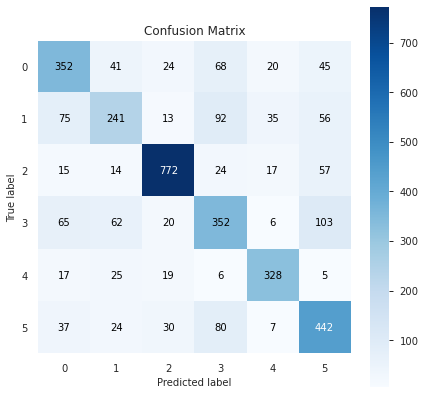

In [36]:
yhat_valid = bestmodel.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("FER confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [37]:
mapper = {
    0: "angry",
    1: "fear",
    2: "happy",
    3: "sad",
    4: "surprise",
    5: "neutral"
}

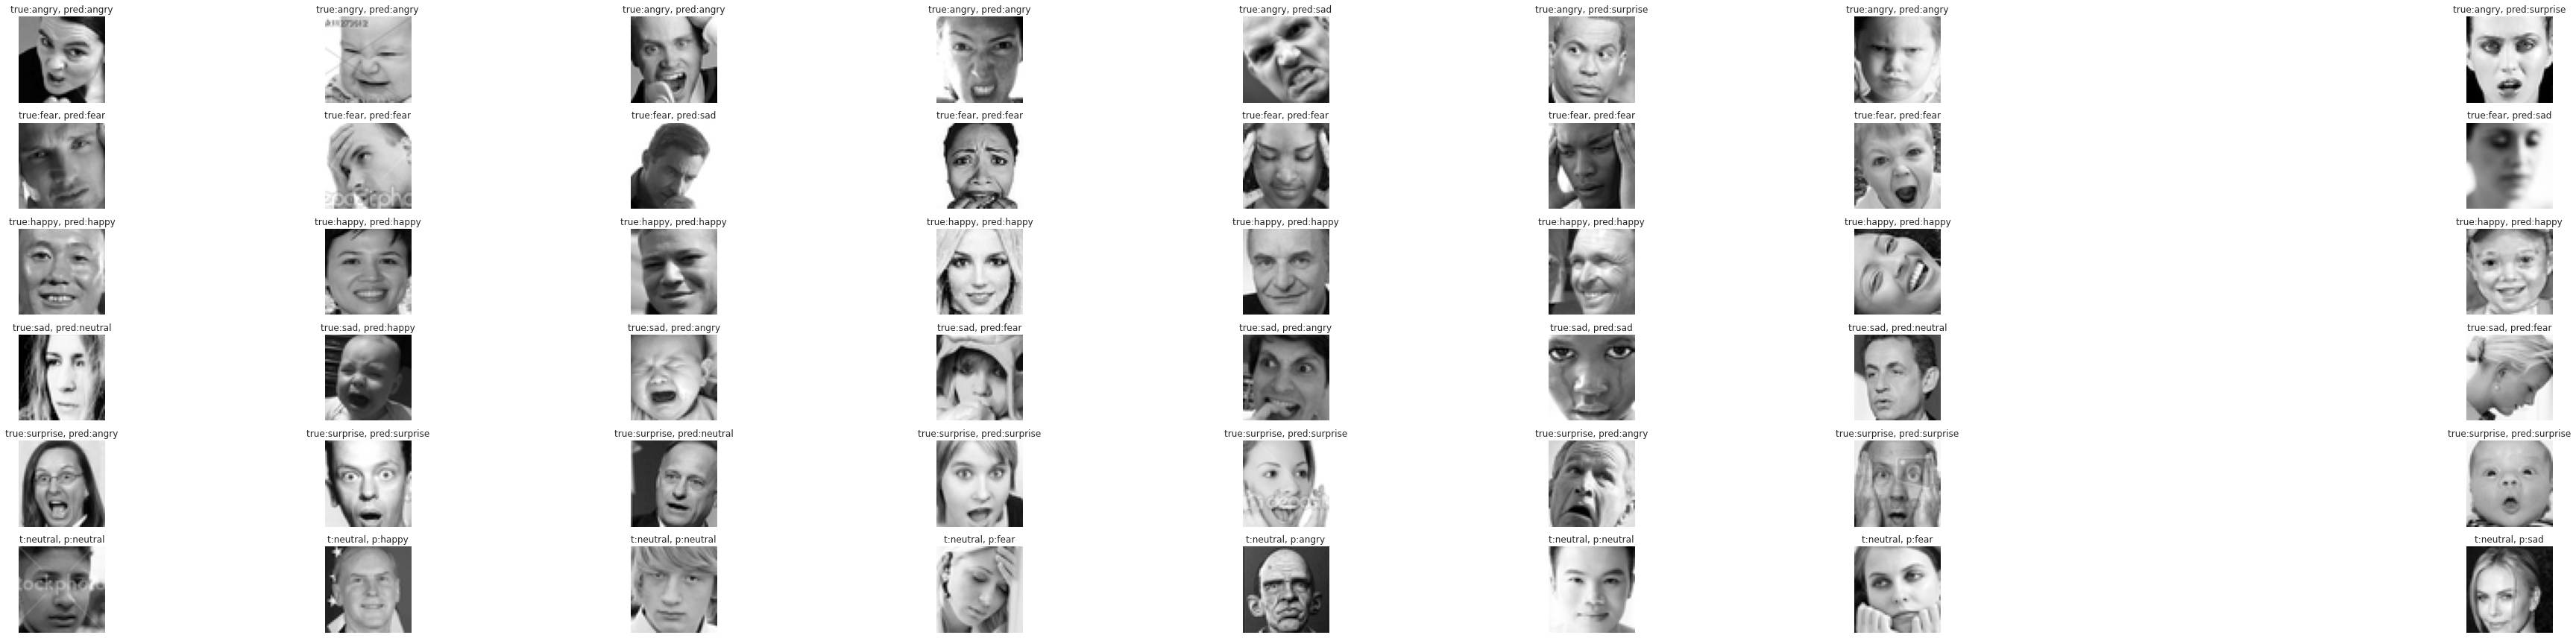

In [38]:
import numpy as np

random_angry_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)
random_surprise_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 5]==1)[0], size=9)

zipped_random=enumerate(zip(random_angry_imgs, random_fear_imgs, random_happy_imgs, random_sad_imgs, random_surprise_imgs, random_neutral_imgs))

fig = pyplot.figure(1, (54, 12))

for i, (angry_idx, fear_idx, happy_idx, sad_idx, surprise_idx, neutral_idx) in zipped_random:
    
        ax = pyplot.subplot(6, 9, i+1)
        sample_img = X_valid[angry_idx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:angry, pred:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(6, 9, i+10)
        sample_img = X_valid[fear_idx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:fear, pred:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(6, 9, i+19)
        sample_img = X_valid[happy_idx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:happy, pred:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(6, 9, i+28)
        sample_img = X_valid[sad_idx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(6, 9, i+37)
        sample_img = X_valid[surprise_idx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:surprise, pred:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(6, 9, i+46)
        sample_img = X_valid[neutral_idx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neutral, p:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()
